In [1]:
import numpy as np
import pandas as pd

To run stata_to_csv_2021.ipynb downlaod the ZA6835_v2-0-0 file from https://search.gesis.org/research_data/ZA6835 and add it to the directory of this project

In [2]:
fileName = 'ZA6835_v2-0-0'
df = pd.read_stata(fileName + ".dta", convert_categoricals=False)


Distribution of v13ba (Vote):
v13ba
 4      814
 1      607
 6      562
 5      337
-97     235
-99     193
 322    190
 7      183
 801    137
-98      63
-83      16
-73       8
Name: count, dtype: int64


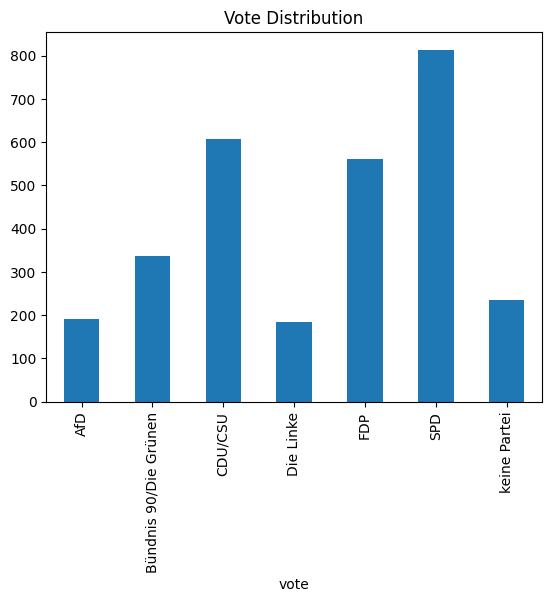

In [3]:
df_recoded = df.copy()

# reducs where field_start is  '2021-08-26' or '2021-09-27'
df_recoded = df_recoded[(df_recoded["field_start"] == "2021-09-27")]

# give numers of row with '-99 keine Angabe' in d3c
missing_d3c = df_recoded[df_recoded["d3c"] == "-99 keine Angabe"].index.tolist()

# remove '-99 keine Angabe' for d3c
df_recoded = df_recoded[df_recoded["d3c"] != "-99 keine Angabe"]

# set '1939 oder frueher' to 1939
df_recoded["d3c"] = df_recoded["d3c"].replace("1931 oder frueher", "1939")


# Age
df_recoded["age"] = 2017 - df_recoded["d3c"].astype(int)

# Female (1 = weiblich, 0 = männlich, np.nan otherwise)
df_recoded["female"] = np.where(
    df_recoded["d1"] == 2, 1, np.where(df_recoded["d1"] == 1, 0, np.nan)
)

# Education
df_recoded["edu"] = np.select(
    [
        (df_recoded[["d6n", "d6m", "d6l", "d6j"]].eq(1).any(axis=1)),
        (df_recoded["d5"].isin([4, 5])),
        (df_recoded["d5"].isin([3, 6])),
        (df_recoded["d5"] == 2),
        (df_recoded["d5"].isin([1, 9])),
    ],
    [5, 4, 3, 2, 1],
    default=np.nan,
)

# Employment
df_recoded["emp"] = np.select(
    [
        (df_recoded["d27"].isin([1, 2, 8, 11])),
        (df_recoded["d27"].isin([7, 10, 12])),
        (df_recoded["d27"].isin([3, 4, 5, 6, 9])),
    ],
    [1, 2, 3],
    default=np.nan,
)

# Household income (raw)
df_recoded["hhincome"] = np.where(df_recoded["d43"] > 0, df_recoded["d43"], np.nan)
df_recoded["hhincome"] = np.select(
    [
        df_recoded["hhincome"] <= 5,
        (df_recoded["hhincome"] >= 6) & (df_recoded["hhincome"] <= 10),
        df_recoded["hhincome"] >= 11,
    ],
    [1, 2, 3],
    default=np.nan,
)

# East/West
df_recoded["east"] = np.where(
    df_recoded["ostwest2"] == 0, 1, np.where(df_recoded["ostwest2"] == 1, 0, np.nan)
)

# Religiosity
df_recoded["religious"] = np.where(df_recoded["d26"] > 0, df_recoded["d26"], np.nan)

# Left-right
df_recoded["leftright"] = np.select(
    [
        df_recoded["v74"].isin([1, 2]),
        df_recoded["v74"].isin([3, 4]),
        df_recoded["v74"].isin([5, 6, 7]),
        df_recoded["v74"].isin([8, 9]),
        df_recoded["v74"].isin([10, 11]),
    ],
    [1, 2, 3, 4, 5],
    default=np.nan,
)

# Party ID
df_recoded["partyid"] = np.select(
    [
        df_recoded["v25a"].isin([1, 2, 3]),
        df_recoded["v25a"] == 4,
        df_recoded["v25a"] == 5,
        df_recoded["v25a"] == 6,
        df_recoded["v25a"] == 7,
        df_recoded["v25a"] == 322,
        df_recoded["v25a"] == 808,
    ],
    [1, 2, 3, 4, 5, 6, 7],
    default=np.nan,
)

# Party ID degree
df_recoded["partyid_degree"] = np.where(
    df_recoded["v26"] == -97,
    6,
    np.where(df_recoded["v26"] > 0, df_recoded["v26"], np.nan),
)

# Inequality
df_recoded["inequality"] = np.select(
    [
        df_recoded["v72d"].isin([1, 2]),
        df_recoded["v72d"] == 3,
        df_recoded["v72d"].isin([4, 5]),
    ],
    [1, 2, 3],
    default=np.nan,
)

# Immigration
df_recoded["immigration"] = np.where(df_recoded["v88"] > 0, df_recoded["v88"], np.nan)
df_recoded["immigration"] = np.select(
    [
        df_recoded["immigration"] <= 5,
        df_recoded["immigration"] == 6,
        df_recoded["immigration"] >= 7,
    ],
    [1, 2, 3],
    default=np.nan,
)


# print distribution of v13ba
print("Distribution of v13ba (Vote):")
print(df_recoded["v13ba"].value_counts(dropna=False))

# Vote
df_recoded["vote"] = np.select(
    [
        df_recoded["v13ba"].isin([1, 2, 3]),
        df_recoded["v13ba"] == 4,
        df_recoded["v13ba"] == 5,
        df_recoded["v13ba"] == 6,
        df_recoded["v13ba"] == 7,
        df_recoded["v13ba"] == 322,
        df_recoded["v13ba"] == -97,
    ],
    [1, 2, 3, 4, 5, 6, 7],
    default=np.nan,
)






# Label mappings
female_labels = {0: "männlich", 1: "weiblich"}
edu_labels = {
    1: "keinen Schulabschluss",
    2: "einen Hauptschulabschluss",
    3: "einen Realschulabschluss",
    4: "Abitur",
    5: "einen Hochschulabschluss",
}
emp_labels = {1: "berufstätig", 2: "nicht berufstätig", 3: "in Ausbildung"}
hhincome_labels = {1: "niedriges", 2: "mittleres", 3: "hohes"}
east_labels = {0: "Westdeutschland", 1: "Ostdeutschland"}
religious_labels = {
    1: "überhaupt nicht religiös",
    2: "nicht sehr religiös",
    3: "etwas religiös",
    4: "sehr religiös",
}
leftright_labels = {
    1: "stark links",
    2: "mittig links",
    3: "in der Mitte",
    4: "mittig rechts",
    5: "stark rechts",
}
partyid_labels = {
    1: "mit der Partei CDU/CSU",
    2: "mit der Partei SPD",
    3: "mit der Partei FDP",
    4: "mit der Partei Bündnis 90/Die Grünen",
    5: "mit der Partei Die Linke",
    6: "mit der Partei AfD",
    8: "mit keiner Partei",
}
partyid_degree_labels = {
    1: "sehr stark ",
    2: "ziemlich stark ",
    3: "mäßig ",
    4: "ziemlich schwach ",
    5: "sehr schwach ",
    6: "",
}
inequality_labels = {
    1: "Maßnahmen ergreifen",
    2: "habe keine Meinung dazu, ob die Regierung Maßnahmen ergreifen sollte",
    3: "keine Maßnahmen ergreifen",
}
immigration_labels = {
    1: "erleichtern",
    2: "weder erleichtern noch einschränken",
    3: "einschränken",
}
vote_labels = {
    1: "CDU/CSU",
    2: "SPD",
    3: "Bündnis 90/Die Grünen",
    4: "FDP",
    5: "Die Linke",
    6: "AfD",
    7: "keine Partei",
}

# Apply labels
df_recoded["female"] = df_recoded["female"].map(female_labels)
df_recoded["edu"] = df_recoded["edu"].map(edu_labels)
df_recoded["emp"] = df_recoded["emp"].map(emp_labels)
df_recoded["hhincome"] = df_recoded["hhincome"].map(hhincome_labels)
df_recoded["east"] = df_recoded["east"].map(east_labels)
df_recoded["religious"] = df_recoded["religious"].map(religious_labels)
df_recoded["leftright"] = df_recoded["leftright"].map(leftright_labels)
df_recoded["partyid"] = df_recoded["partyid"].map(partyid_labels)
df_recoded["partyid_degree"] = df_recoded["partyid_degree"].map(partyid_degree_labels)
df_recoded["inequality"] = df_recoded["inequality"].map(inequality_labels)
df_recoded["immigration"] = df_recoded["immigration"].map(immigration_labels)
df_recoded["vote"] = df_recoded["vote"].map(vote_labels)

# Party string
df_recoded["party"] = (
    df_recoded["partyid_degree"].fillna("") + df_recoded["partyid"].fillna("")
).replace("", np.nan)

# Show first few recoded rows
df_trimmed = df_recoded[
    [
        "age",
        "female",
        "edu",
        "emp",
        "hhincome",
        "east",
        "religious",
        "leftright",
        "party",
        "inequality",
        "immigration",
        "vote",
    ]
]


# display(df_recoded["v25a"])

# print(df_recoded["v25a"].unique())


# cate_v25a = df_recoded["v25a"].astype("category")
# # barchart of v25a
# cate_v25a.value_counts().sort_index().plot(
#     kind="bar", title="v25a - Party ID Distribution"
# )


# plot bar chart of vote distribution
vote_counts = (
    df_recoded["vote"]
    .value_counts()
    .sort_index()
    .plot(
        kind="bar",
        title="Vote Distribution",
    )
)



In [4]:

df_trimmed = df_trimmed.dropna().reset_index(drop=True)

# Generate prompt column as described
df_trimmed['prompt'] = df_trimmed.apply(lambda row: f"""Ich bin {row['age']} Jahre alt und {row['female']}. Ich habe {row['edu']}, ein {row['hhincome']} monatliches Haushalts-Nettoeinkommen und ich bin {row['emp']}. Ich bin {row['religious']}. Politisch-ideologisch ordne ich mich {row['leftright']} ein. Ich identifiziere mich {row['party']} und habe {row['vote']} gewählt. Ich lebe in {row['east']}. Ich finde, die Regierung sollte die Einwanderung {row['immigration']} und {row['inequality']}, um die Einkommensunterschiede zu verringern.""", axis=1)
df_trimmed['you_prompt'] = df_trimmed.apply(lambda row: f"""Du bist {row['age']} Jahre alt und {row['female']}. Du hast {row['edu']}, ein {row['hhincome']} monatliches Haushalts-Nettoeinkommen und du bist {row['emp']}. Du bist {row['religious']}. Politisch-ideologisch ordnest du dich {row['leftright']} ein. Du identifizierst dich {row['party']} und hast {row['vote']} gewählt. Du lebst in {row['east']}. Du findest, die Regierung sollte die Einwanderung {row['immigration']} und {row['inequality']}, um die Einkommensunterschiede zu verringern.""", axis=1)

df_trimmed['prompt'].to_list()
df_trimmed[df_trimmed['vote'].str.contains('keine Partei', na=False)].iloc[:10]['prompt'].to_list()

['Ich bin 22 Jahre alt und männlich. Ich habe einen Realschulabschluss, ein mittleres monatliches Haushalts-Nettoeinkommen und ich bin berufstätig. Ich bin überhaupt nicht religiös. Politisch-ideologisch ordne ich mich in der Mitte ein. Ich identifiziere mich ziemlich stark mit der Partei FDP und habe keine Partei gewählt. Ich lebe in Westdeutschland. Ich finde, die Regierung sollte die Einwanderung einschränken und Maßnahmen ergreifen, um die Einkommensunterschiede zu verringern.',
 'Ich bin 38 Jahre alt und männlich. Ich habe einen Realschulabschluss, ein mittleres monatliches Haushalts-Nettoeinkommen und ich bin berufstätig. Ich bin überhaupt nicht religiös. Politisch-ideologisch ordne ich mich mittig rechts ein. Ich identifiziere mich mäßig mit der Partei CDU/CSU und habe keine Partei gewählt. Ich lebe in Westdeutschland. Ich finde, die Regierung sollte die Einwanderung einschränken und Maßnahmen ergreifen, um die Einkommensunterschiede zu verringern.',
 'Ich bin 67 Jahre alt und w

In [5]:
df_trimmed.to_csv(fileName + '.csv', index=False, sep=';')